# Random Forest - Bike Rental (Regression)
[h3-random-forest-baggging.ipynb](https://github.com/kyopark2014/ML-Algorithms/blob/main/xgboost/src/ch3-random-forest-baggging.ipynb)

In [38]:
import pandas as pd
import numpy as np

In [39]:
df_bikes = pd.read_csv('https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter03/bike_rentals_cleaned.csv')

df_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1.0,0.0,1.0,0.0,6.0,0.0,2,0.344167,0.363625,0.805833,0.160446,985
1,2,1.0,0.0,1.0,0.0,0.0,0.0,2,0.363478,0.353739,0.696087,0.248539,801
2,3,1.0,0.0,1.0,0.0,1.0,1.0,1,0.196364,0.189405,0.437273,0.248309,1349
3,4,1.0,0.0,1.0,0.0,2.0,1.0,1,0.200000,0.212122,0.590435,0.160296,1562
4,5,1.0,0.0,1.0,0.0,3.0,1.0,1,0.226957,0.229270,0.436957,0.186900,1600


In [41]:
df_bikes['cnt'].value_counts()

5119    2
4401    2
1977    2
6824    2
5191    2
       ..
6273    1
5501    1
4760    1
1683    1
4097    1
Name: cnt, Length: 696, dtype: int64

### Define feature and target

In [3]:
X_bikes = df_bikes.iloc[:,:-1]
y_bikes = df_bikes.iloc[:,-1]

### RandomForestRegressor

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10, random_state=2, n_jobs=-1)

print(rf.get_params(deep=True))

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': -1, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}


### cross_val_score

In [5]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_bikes, y_bikes, scoring='neg_mean_squared_error', cv=10)

rmse = np.sqrt(-scores)
print('RMSE:', np.round(rmse, 3))
print('Avg. RMSE: %0.3f' % (rmse.mean()))

RMSE: [ 801.486  579.987  551.347  846.698  895.05  1097.522  893.738  809.284
  833.488 2145.046]
Avg. RMSE: 945.365


### Evaluation

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_bikes, y_bikes, random_state=2)

In [7]:
rf.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)

print('RMSE:', np.round(rmse, 3))

RMSE: 689.644
Avg. RMSE: 689.644


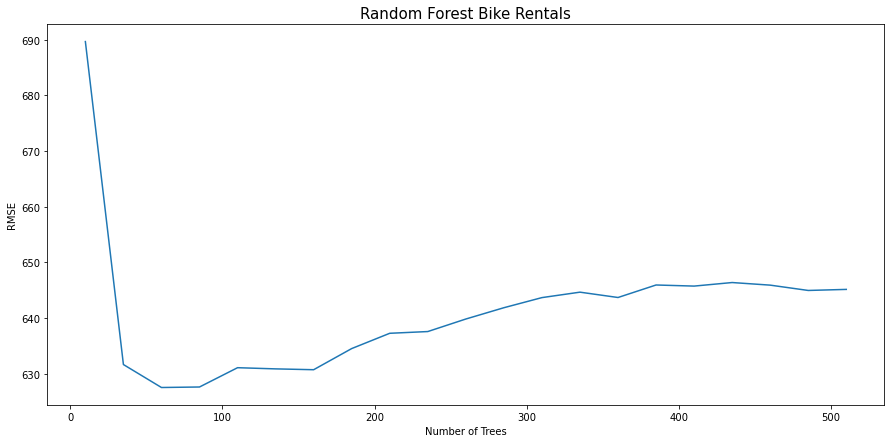

In [8]:
from sklearn.metrics import mean_squared_error

rmse_scores = []
estimators = []

rf = RandomForestRegressor(warm_start=True, n_jobs=-1, random_state=2)

est = 10

for i in range(21):
    rf.set_params(n_estimators=est)

    rf.fit(X_train, y_train)
    
    rmse = mean_squared_error(y_test, rf.predict(X_test), squared=False)
    
    rmse_scores.append(rmse)
    estimators.append(est)
    
    est += 25

import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(estimators, rmse_scores)
plt.xlabel('Number of Trees')
plt.ylabel('RMSE')
plt.title('Random Forest Bike Rentals', fontsize=15)
plt.show()

### cross_val_score

In [9]:
rf = RandomForestRegressor(n_estimators=50, warm_start=True, n_jobs=-1, random_state=2)
   
scores = cross_val_score(rf, X_bikes, y_bikes, scoring='neg_mean_squared_error', cv=10)
    
rmse = np.sqrt(-scores)    
print('RMSE:', np.round(rmse, 3))
print('Avg. RMSE: %0.3f' % (rmse.mean()))

RMSE: [ 836.482  541.898  533.086  812.782  894.877  881.117  794.103  828.968
  772.517 2128.148]
Avg. RMSE: 902.398


### HPO - RandomForestRegressor

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE

params={'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05],
            'min_samples_split':[2, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1],
            'min_samples_leaf':[1,2,4,6,8,10,20,30],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
            'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
            'max_features':['sqrt', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,2,4,6,8,10,20]}
runs = 16

rand_reg = RandomizedSearchCV(rf, params, n_iter=runs, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, random_state=2)    
rand_reg.fit(X_train, y_train)

best_model = rand_reg.best_estimator_
best_params = rand_reg.best_params_
print("Best parameter:", best_params)
    
best_score = np.sqrt(-rand_reg.best_score_)
print("Avg. RMSE(Train): {:.3f}".format(best_score))

y_pred = best_model.predict(X_test)
rmse_test = MSE(y_test, y_pred)**0.5
print('Avg. RMSE(Test): {:.3f}'.format(rmse_test))

Best parameter: {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.03, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.05, 'max_leaf_nodes': 25, 'max_features': 0.7, 'max_depth': None}
Avg. RMSE(Train): 765.707
Avg. RMSE(Test): 704.318


In [25]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE

def randomized_search_reg(params, runs=16, reg=RandomForestRegressor(random_state=2, n_jobs=-1)):
    rand_reg = RandomizedSearchCV(reg, params, n_iter=runs, scoring='neg_mean_squared_error', cv=10, n_jobs=-1, random_state=2)    
    rand_reg.fit(X_train, y_train)

    best_model = rand_reg.best_estimator_
    best_params = rand_reg.best_params_
    print("Best parameter:", best_params)
    
    best_score = np.sqrt(-rand_reg.best_score_)
    print("Avg. RMSE(Train): {:.3f}".format(best_score))

    y_pred = best_model.predict(X_test)
    rmse_test = MSE(y_test, y_pred)**0.5
    print('Avg. RMSE(Test): {:.3f}'.format(rmse_test))
    
    return best_model

In [26]:
best_model = randomized_search_reg(
    params={'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05],
            'min_samples_split':[2, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1],
            'min_samples_leaf':[1,2,4,6,8,10,20,30],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
            'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
            'max_features':['sqrt', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,2,4,6,8,10,20]})

Best parameter: {'min_weight_fraction_leaf': 0.0, 'min_samples_split': 0.03, 'min_samples_leaf': 6, 'min_impurity_decrease': 0.05, 'max_leaf_nodes': 25, 'max_features': 0.7, 'max_depth': None}
Avg. RMSE(Train): 759.076
Avg. RMSE(Test): 701.802


RandomForestRegressor(max_features=0.7, max_leaf_nodes=25,
                      min_impurity_decrease=0.05, min_samples_leaf=6,
                      min_samples_split=0.03, n_jobs=-1, random_state=2)

In [33]:
best_model = randomized_search_reg(
    params={'min_samples_leaf':[1,2,4,6,8,10,20,30],
            'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
            'max_features':['sqrt', 0.8, 0.7, 0.6, 0.5, 0.4],
            'max_depth':[None,4,6,8,10,12,15,20],
            'n_estimators':[100]}, 
    runs=20)

Best parameter: {'n_estimators': 100, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.1, 'max_features': 0.6, 'max_depth': 12}
Avg. RMSE(Train): 675.128
Avg. RMSE(Test): 619.014


### Verify the new hyperparameters

In [34]:
params = best_model.get_params(deep=True)
print(params)

min_samples_leaf = params['min_samples_leaf']
min_impurity_decrease = params['min_impurity_decrease']
max_features = params['max_features']
max_depth = params['max_depth']
n_estimators = params['n_estimators']
max_leaf_nodes = params['max_leaf_nodes']
min_samples_split = params['min_samples_split']
warm_start = params['warm_start']

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 12, 'max_features': 0.6, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.1, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}


In [35]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=2, n_jobs=-1,
    min_samples_leaf=min_samples_leaf, min_impurity_decrease=min_impurity_decrease, max_features=max_features, max_depth=max_depth,
    n_estimators=n_estimators, max_leaf_nodes=max_leaf_nodes, min_samples_split=min_samples_split, warm_start=warm_start)

print(model.get_params(deep=True))
    
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_bikes, y_bikes, scoring='neg_mean_squared_error', cv=10)

rmse = np.sqrt(-scores)
print('RMSE:', np.round(rmse, 3))
print('Avg. RMSE: %0.3f' % (rmse.mean()))

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': 12, 'max_features': 0.6, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.1, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}
RMSE: [ 818.354  514.173  547.392  814.059  769.54   730.025  831.376  794.634
  756.83  1595.237]
Avg. RMSE: 817.162


In [36]:
model.fit(X_train, y_train)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(y_test, model.predict(X_test), squared=False)

print('RMSE:', np.round(rmse, 3))

RMSE: 619.014


### Shuffle

In [14]:
from sklearn.utils import shuffle
df_shuffle_bikes = shuffle(df_bikes, random_state=2)
df_shuffle_bikes.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
671,672,4.0,1.0,11.0,0.0,5.0,1.0,1,0.355000,0.356042,0.522083,0.266175,5847
199,200,3.0,0.0,7.0,0.0,2.0,1.0,1,0.776667,0.747479,0.650417,0.130600,4541
77,78,1.0,0.0,3.0,0.0,6.0,0.0,1,0.472500,0.466525,0.379167,0.368167,3117
225,226,3.0,0.0,8.0,0.0,0.0,0.0,2,0.676667,0.624388,0.817500,0.222633,3820
37,38,1.0,0.0,2.0,0.0,1.0,1.0,1,0.271667,0.303658,0.738333,0.045408,1712


In [15]:
X_shuffle_bikes = df_shuffle_bikes.iloc[:,:-1]
y_shuffle_bikes = df_shuffle_bikes.iloc[:,-1]

In [16]:
rf = RandomForestRegressor(n_estimators=100, min_impurity_decrease=0.1, max_features=0.6, max_depth=12, n_jobs=-1, random_state=2)
   
scores = cross_val_score(rf, X_shuffle_bikes, y_shuffle_bikes, scoring='neg_mean_squared_error', cv=10)
    
rmse = np.sqrt(-scores)
print('RMSE:', np.round(rmse, 3))
print('Avg. RMSE: %0.3f' % (rmse.mean()))

RMSE: [630.093 686.673 468.159 526.676 593.033 724.575 774.402 672.63  760.253
 616.797]
Avg. RMSE: 645.329
